In [1]:
!pip install torch-summary
!pip install torch-xla==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 MB 18.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.3 MB/s eta 0:00:00eta 0:00:01
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.155.0
    Uninstalling google-api-python-client-2.155.0:
      Successfully uninstalled google-api-python-client-2.155.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.0 which is incompatible.
pydrive2 1.21.3 requires google-api-python-client>=1.12.5, but you have google-api-python-client 1.8.0 which is incompatible.
pydrive2 1.21.3 requ

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import warnings

warnings.simplefilter('ignore')

In [3]:
class Pipeliner:
    def __init__(self, data_path=None, image_extensions=(".jpg", ".png", ".jpeg"), device = 'cpu', split_ratio=(0.8, 0.1, 0.1), 
                 resized=None, cropped=None, is_augmented=False, horizontal_flip=False, p_horizontal=0.5, 
                 vertical_flip=False, p_vertical=0.5, jitter=False, jit_brightness=0.2, jit_contrast=0.2,
                 jit_saturation=0.2, jit_hue=0.1, rotation=0, gaussian_blur=False, blur_kernel=(5, 5), normalize=True,
                 nor_mean=[0.485, 0.456, 0.406], nor_std=[0.229, 0.224, 0.225], criterion="CrossEntropyLoss", batch_size=32, epochs=10,
                 optimizer=lambda params: optim.Adam(params, lr=0.001), scheduler=None, model_name=None, model=None, weights=None, 
                 random_state=42):
        # Dataset and preprocessing
        self.data_path = data_path
        self.image_extensions = image_extensions
        self.split_ratio = split_ratio
        self.resized = resized
        self.cropped = cropped
        self.normalize = normalize
        self.nor_mean = nor_mean
        self.nor_std = nor_std
        self.random_state = random_state
        
        # Augmentation
        self.is_augmented = is_augmented       
        self.horizontal_flip = horizontal_flip
        self.p_horizontal = p_horizontal
        self.vertical_flip = vertical_flip
        self.p_vertical = p_vertical
        self.jitter = jitter
        self.jit_brightness = jit_brightness
        self.jit_contrast = jit_contrast
        self.jit_saturation = jit_saturation
        self.jit_hue = jit_hue
        self.rotation = rotation
        self.gaussian_blur = gaussian_blur
        self.blur_kernel = blur_kernel
        
        # Model
        self.model_name = model_name
        self.model = model
        self.weights = weights
        
        # Training configuration
        self.batch_size = batch_size
        self.epochs = epochs
        self.criterion = getattr(nn, criterion)()
        self.optimizer = optimizer
        self.scheduler = scheduler
        if (device == 'tpu'):
            try:
                import torch_xla.core.xla_model as xm
                self.device = xm.xla_device()
                print(f"Using TPU: {self.device}")
            except Exception as e:
                print(f"TPU not available. Falling back to CPU.")
                self.device = torch.device("cpu")
        elif (device == 'cuda'):
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
                print(f"Using GPU: {self.device}")
            else:
                print(f"GPU not available. Falling back to CPU.")
                self.device = torch.device("cpu")

        else:
            self.device = torch.device("cpu")
            print(f"Using CPU.")

        self.loss_per_epoch = []
        self.acc_per_epoch = []
        self.val_loss_per_epoch = []
        self.val_acc_per_epoch = []
        print ("Initialization done")
    def _img_transform(self):
        transform_list = []
        if self.resized: transform_list.append(transforms.Resize(self.resized))
        if self.cropped: transform_list.append(transforms.CenterCrop(self.cropped))
        transform_list.append(transforms.ToTensor())
        if self.normalize: transform_list.append(transforms.Normalize(mean=self.nor_mean, std=self.nor_std))
        return transforms.Compose(transform_list)
    
    def _img_augmented(self, visual=False):
        transform_list = []
        if self.horizontal_flip==True: transform_list.append(transforms.RandomHorizontalFlip(p=self.p_horizontal))
        if self.vertical_flip==True: transform_list.append(transforms.RandomVerticalFlip(p=self.p_vertical))
        if self.jitter==True: 
            transform_list.append(transforms.ColorJitter(
                brightness=self.jit_brightness, 
                contrast=self.jit_contrast, 
                saturation=self.jit_saturation, 
                hue=self.jit_hue
            ))
        if self.rotation: transform_list.append(transforms.RandomRotation(degrees=self.rotation, fill=0))
        if self.gaussian_blur==True: transform_list.append(transforms.GaussianBlur(kernel_size=self.blur_kernel))
        if visual==False: 
            transform_list += self._img_transform().transforms
        else: 
            transform_list.append(transforms.ToTensor())
        return transforms.Compose(transform_list)

    def _img_visualization(self, augmented=False): 
        from PIL import Image

        for label in self.labels:
            class_path = os.path.join(self.data_path, label)
            img_list = os.listdir(class_path)
            img_rand = random.sample(img_list, k = min(5, len(img_list)))
            fig, ax = plt.subplots(1, len(img_rand), figsize = (14, 3)) 
            plt.suptitle(f'Sample from class: {label}', fontsize = 14)
            for idx, img_name in enumerate(img_rand):
                img_dir = os.path.join(class_path, img_name)
                img = Image.open(img_dir).convert('RGB')
                if augmented: 
                    img = self._img_augmented(visual=True)(img)
                    img = transforms.ToPILImage()(img)
                ax[idx].imshow(img)
                ax[idx].axis('off')
            plt.subplots_adjust(wspace = 0.1)
            plt.show()
    def load_dataset(self, dog_barplot=8):
        from sklearn.model_selection import StratifiedShuffleSplit
        from torch.utils.data import Dataset, DataLoader, Subset
        from torchvision.datasets import ImageFolder
        import random


        assert self.data_path, "data_path must be specified."        
        dataset = datasets.ImageFolder(root=self.data_path, transform=self._img_transform())
        print("Loading complete")

        self.labels = [label for label in os.listdir(self.data_path) if label.find(".") == -1] 
        print("Printing samples of each class: ")
        self._img_visualization()

        print("Distribution of the dataset: ")
        label_size = []
        for label in self.labels:
            class_path = os.path.join(self.data_path, label)
            img_list = os.listdir(class_path)
            label_size.append(len(img_list))
        
        len_label = len(self.labels)
        color_list = plt.cm.viridis(range(len(self.labels) * dog_barplot))
        color_list = [color for idx, color in enumerate(color_list) if idx % dog_barplot == 0]
        
        plt.bar(self.labels, label_size, color=color_list)
        for idx, val in enumerate(label_size):
            plt.text(idx, val, str(val), ha='center', va='bottom', fontstyle="oblique", fontsize=10)
        plt.show()

        dataset_size = len(dataset)
        
        train_size = int(self.split_ratio[0] * dataset_size)
        val_size = int(self.split_ratio[1] * dataset_size)
        test_size = dataset_size - train_size - val_size
        
        print(f"Train dataset size: {train_size}")
        print(f"Validation dataset size: {val_size}")
        print(f"Test dataset size: {test_size}")

        targets = dataset.targets
        sss_train_rest = StratifiedShuffleSplit(n_splits=1, test_size=1 - self.split_ratio[0], random_state=self.random_state)
        for train_idx, val_test_idx in sss_train_rest.split(range(dataset_size), targets):
            train_dataset = Subset(dataset, train_idx)
            val_test_dataset = Subset(dataset, val_test_idx)
        
        sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=self.split_ratio[2] / (self.split_ratio[1] + self.split_ratio[2]), random_state=self.random_state)
        val_test_targets = [targets[idx] for idx in val_test_idx]
        for val_idx, test_idx in sss_val_test.split(range(len(val_test_dataset)), val_test_targets):
            val_dataset = Subset(val_test_dataset, val_idx)
            test_dataset = Subset(val_test_dataset, test_idx)
        
        sample_img, _ = train_dataset[0]
        self.train_img_size = sample_img.size()
        
        if self.is_augmented: 
            train_dataset.dataset.transform = self._img_augmented()
            print("Printing samples of each class after augmentation: ")
            print(" "*10, "State of augmentation param:{", end='')
            if self.horizontal_flip==True: print(f'p_horizontal_flip={self.p_horizontal}', end='')
            if self.vertical_flip==True: print(f'p_horizontal_flip={self.p_vertical}', end='')
            if self.jitter==True: print(f'jitter: [brightness={self.jit_brightness}, contrast={self.jit_contrast}, saturation={self.jit_saturation},hue={self.jit_hue}]', end='')
            if self.rotation: print(f'rotation={self.rotation}', end='')
            if self.gaussian_blur==True: print('gaussian_blur=True', end='')
            print('}')    
            self._img_visualization(augmented=True)
        
        if ('xla' in str(self.device)):
            import torch_xla.distributed.parallel_loader as pl

            self.train_loader = pl.MpDeviceLoader(DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, generator=torch.Generator().manual_seed(self.random_state)), self.device)
            self.val_loader = pl.MpDeviceLoader(DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False), self.device)
            self.test_loader = pl.MpDeviceLoader(DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False), self.device)
            print("Dataset wraped successfully")
        else: 
            self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, generator=torch.Generator().manual_seed(self.random_state))
            self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
            self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
    def build_model(self):
        from torchsummary import summary

        if self.model: 
            print("Using a custom model.")
        else:
            assert self.model_name, "Either a custom model or a model_name must be provided."
            try:
                model_class = getattr(models, self.model_name.lower())
                self.model = model_class(weights=self.weights)
                num_classes = len(set(self.labels))
                if hasattr(self.model, "fc"):
                    in_features = self.model.fc.in_features
                    self.model.fc = nn.Linear(in_features, num_classes)
                elif hasattr(self.model, "classifier"):
                    in_features = self.model.classifier[-1].in_features
                    self.model.classifier[-1] = nn.Linear(in_features, num_classes)
                else: 
                    raise NotImplementedError(f"Manual adjustment required for '{self.model_name}'.")
            except AttributeError as e:
                raise ValueError(f"Model '{self.model_name}' is not available in torchvision.models. Error: {e}")        

        
        self.model = self.model.to(self.device) 
       
        print ("Printin param...")
        summary(self.model, self.train_img_size)
        self.model = self.model.to(self.device)

    def _evaluate(self, mode="val", criterion=None):
        dataloader = self.val_loader if mode == "val" else self.test_loader
        self.model.eval() 
        running_loss, correct_samples, total_samples = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                if criterion:
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                correct_samples += (outputs.argmax(dim=1) == labels).sum().item()
                total_samples += labels.size(0)
        avg_loss = running_loss / len(dataloader) if criterion else None
        accuracy = correct_samples / total_samples
        return (avg_loss, accuracy) if avg_loss is not None else accuracy
    def train(self):
        is_tpu = False
        if 'xla' in str(self.device):
            from tqdm import tqdm
            is_tpu = True
        else:
            import tensorflow as tf
            from keras.utils import Progbar
            
        criterion = self.criterion
        optimizer = self.optimizer(self.model.parameters())
        scheduler = self.scheduler(optimizer) if self.scheduler else None
        best_val_loss = float('inf')
        epochs_with_no_improve = 0
        best_score, best_model = None, None
        
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")
            self.model.train()
            running_loss, correct_samples, total_samples = 0.0, 0, 0
            if is_tpu:
                progbar = tqdm(self.train_loader,
                                   total=len(self.train_loader),
                                   desc=f"Epoch {epoch + 1}/{self.epochs}",
                                   ncols=100,
                                   unit='batch')
                loader = progbar
            else:
                progbar = Progbar(target=len(self.train_loader), verbose=1)
                loader = self.train_loader
            for batch_idx, (inputs, labels) in enumerate(loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                if ('xla' in str(self.device)):
                    xm.optimizer_step(optimizer)
                    xm.mark_step() 
                else: 
                    optimizer.step()
                
                running_loss += loss.item()
                correct_samples += (outputs.argmax(dim=1) == labels).sum().item()
                total_samples += labels.size(0)
    
                avg_loss = running_loss / (batch_idx + 1)
                avg_accuracy = correct_samples / total_samples
                if is_tpu:
                    progbar.set_postfix(loss=avg_loss, accuracy=avg_accuracy)
                else:
                    progbar.update(batch_idx + 1, values=[("loss", avg_loss), ("accuracy", avg_accuracy)])
    
            epoch_loss = running_loss / len(self.train_loader)
            epoch_accuracy = correct_samples / total_samples
            
            print(f"Epoch {epoch + 1} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")

            self.loss_per_epoch.append(epoch_loss)
            self.acc_per_epoch.append(epoch_accuracy)

            val_loss, val_accuracy = self._evaluate(mode="val", criterion=criterion)
            self.val_loss_per_epoch.append(val_loss)
            self.val_acc_per_epoch.append(val_accuracy)
            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")
            if scheduler:
                scheduler.step()
            
            if best_val_loss is None or val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model.state_dict()
                print("Best model weights saved.")
        return best_model
    def _get_test_dataset_eval(self):
        y_true, y_pred = [], []
        for inputs, labels in self.test_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs)
            _, pred = torch.max(outputs.data, 1)
            pred = pred.detach().cpu().numpy()
            labels = labels.cpu().numpy()
            y_true = np.append(y_true, labels)
            y_pred = np.append(y_pred, pred)
        return y_true, y_pred
    def _f1_score(self, y_true, y_pred):
        report = classification_report(y_true, y_pred, target_names=self.labels)
        print("Classification Report") 
        print(report)
    
    def _confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(15, 5))
        sns.set(font_scale=1.2)
        ax = sns.heatmap(cm, annot=True, fmt='g', cbar=True, square=True)
        ax.set_xlabel('Predicted Labels', fontsize=18)
        ax.set_ylabel('True Labels', fontsize=18)
        ax.set_title('Confusion Matrix', fontsize=22)
        ax.xaxis.set_ticklabels(self.labels, rotation=45)
        ax.yaxis.set_ticklabels(self.labels, rotation=0)
        plt.tight_layout() 
        plt.show()

    def _epoch_metric_visualization(self):
        y_axis = [int(i) for i in range(1, self.epochs + 1)]
        _, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].plot(y_axis, self.loss_per_epoch, color='blue', label='train')
        ax[0].plot(y_axis, self.val_loss_per_epoch, color='orange', label='test')
        ax[0].set_title("Loss in training and testing phase")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        
        ax[1].plot(y_axis, self.acc_per_epoch, color='blue', label='train')
        ax[1].plot(y_axis, self.val_acc_per_epoch, color='orange', label='test')
        ax[1].set_title("Acc in training and testing phase")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Acc")
        ax[1].legend()
        
        plt.show()
    def report(self):
        self._epoch_metric_visualization()
        y_true, y_pred = self._get_test_dataset_eval()
        self._f1_score(y_true, y_pred)
        self._confusion_matrix(y_true, y_pred)

TPU not available. Falling back to CPU.
Initialization done
Loading complete
Printing samples of each class: 


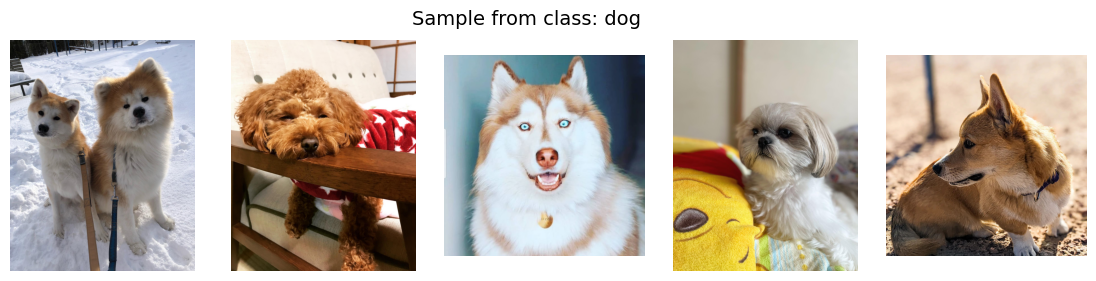

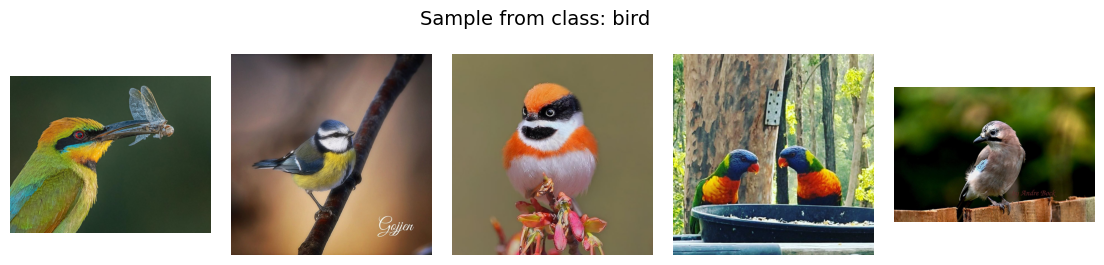

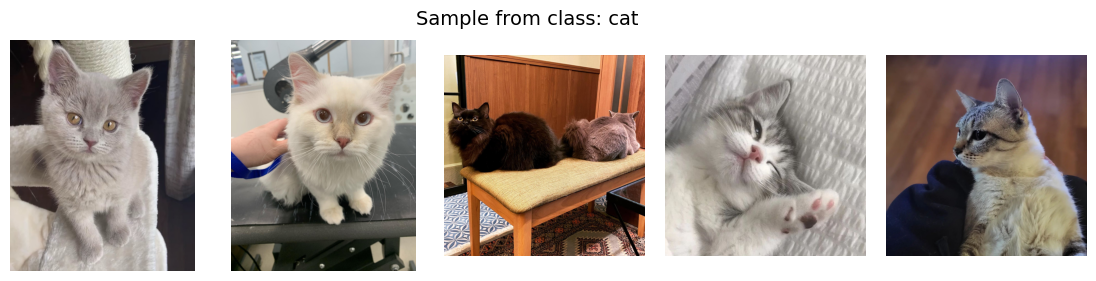

Distribution of the dataset: 


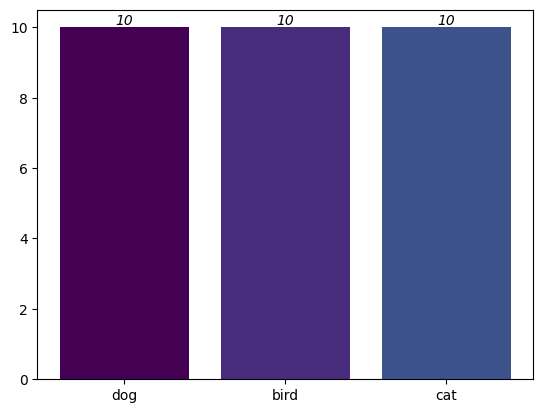

Train dataset size: 24
Validation dataset size: 3
Test dataset size: 3
Printin param...
Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 1, 1]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 1, 1]            --
|    |    └─Conv2d: 3-1                       [-1, 32, 1, 1]            864
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 1, 1]            64
|    |    └─SiLU: 3-3                         [-1, 32, 1, 1]            --
|    └─Sequential: 2-2                        [-1, 16, 1, 1]            --
|    |    └─MBConv: 3-4                       [-1, 16, 1, 1]            1,448
|    └─Sequential: 2-3                        [-1, 24, 1, 1]            --
|    |    └─MBConv: 3-5                       [-1, 24, 1, 1]            6,004
|    |    └─MBConv: 3-6                       [-1, 24, 1, 1]            10,710
|    └─Sequential: 2-4                        [-1, 40, 1, 1]           

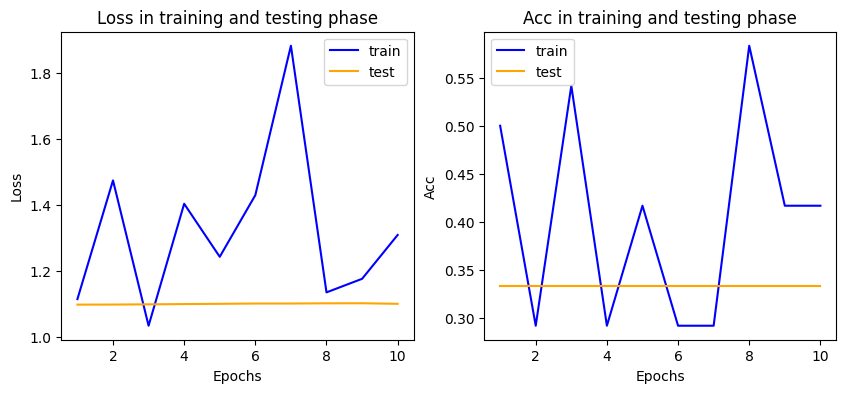

Classification Report
              precision    recall  f1-score   support

         dog       0.00      0.00      0.00         1
        bird       0.00      0.00      0.00         1
         cat       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



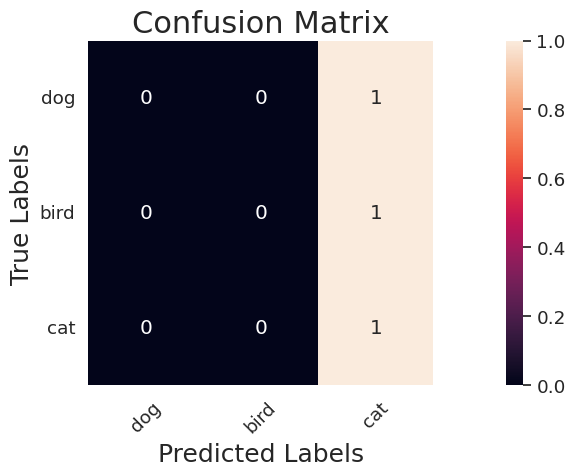

In [4]:
pipeline = Pipeliner(
    data_path="/kaggle/input/sample-animal-set",
    device='tpu',
    resized=(1, 1),
    is_augmented=False,
    batch_size=16,
    epochs=10,
    model_name='efficientnet_b0',
    weights=None,
    optimizer=lambda params: optim.Adam(params, lr=0.001),  
)
pipeline.load_dataset(dog_barplot=32)

pipeline.build_model()

saved_model = pipeline.train()

pipeline.report()